https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
keras = tf.keras

2021-08-29 09:12:33.875295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu
2021-08-29 09:12:33.875376: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
from keras import Sequential
from keras.layers import LSTM, Dense

In [11]:
def load_data():
    folder = '/home/fra/DataMart/datacentre/opendata/UCI/household_power_consumption.txt'
    # load all data
    df = pd.read_csv(folder, sep=';', 
        header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, 
        index_col=['datetime'])

    # imputation
    # mark all missing values
    df.replace('?', np.nan, inplace=True)
    # make dataset numeric
    df = df.astype('float32')

    # fill missing values with a value at the same time one day ago
    def fill_missing(values):
        one_day = 60 * 24
        for row in range(values.shape[0]):
            for col in range(values.shape[1]):
                if np.isnan(values[row, col]):
                    values[row, col] = values[row - one_day, col]

    # fill missing
    fill_missing(df.values)
    # add a column for for the remainder of sub metering
    values = df.values
    
    # create new column
    df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
    return df

In [13]:
def split_dataset(data):
    "create two 3d array with shape (num_weeks, num_days, num_features)"
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

### get data

In [14]:
df = load_data()

In [15]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.099998


In [17]:
df.shape

(2075259, 8)

### Group by Day

In [27]:
daily_groups = df.resample('D')

In [28]:
daily_data = daily_groups.sum()

In [30]:
daily_data.shape

(1442, 8)

In [31]:
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781


### split train / test

In [32]:
train, test = split_dataset(daily_data.values)

In [33]:
train.shape, test.shape

((159, 7, 8), (46, 7, 8))

### Model Evaluation

In [53]:
from sklearn.metrics import mean_squared_error 

In [56]:
def evaluate_forecasts(actual, predicted):
    "overall and RMSE for each day"
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [48]:
def evaluate_model(train, test, n_input):
    "trian and evaluate model with weekly sliding window"
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    
    # walk-forward validation over each week
    predictions = list()
    # out of sample testing
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [7]:
# summarize scores
def summarize_scores(name, score, scores):
    ""
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [39]:
def to_supervised(train, n_input, n_out=7):
    "split feature and target"
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [34]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [50]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [57]:
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [394.399] 410.1, 403.1, 377.0, 394.3, 398.0, 323.0, 444.8


In [63]:
import matplotlib.pyplot as plt

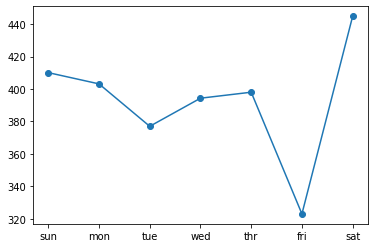

In [65]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm')
plt.show()

### TODO: Amend code - hard to read

### TODO: Encoder-Decoder LSTM Model 

### TODO: baseline